# Fig 1 - resistance in terms of mean and variance

## Overview:

N sprays most important thing for resistance

Effect of changes to initial distributions - variance and mean

(maths in appendix proves it)

And resistance increases with dose

Then can say simple things about resistance management, but yield and econ more complex (figs 2 onwards address)

FIG:
1. Mean of dist vs severity in diff cases (doses / sprays)
2. Mean of dist vs n sprays/dose
3. Variance vs change in following year or vs mean in year X

## Required data:

Figures 1 and 2 need df based on scan over:

`Sprays = 1,2,3`

`doses = 0.1,0.2,...,1`

`years=0,1,...,15`

With columns:

- `sprays`
- `dose`
- `year`
- `yield_vec`
- `dis_sev`
- `econ`
- `fung_mean_start`
- `fung_var_start`
- `fung_mean_end`
- `fung_var_end`


In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib widget

In [2]:
import pandas as pd
from scipy.stats import norm
from scipy import signal

import seaborn as sns
from math import floor

import numpy as np
import matplotlib.pyplot as plt

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

import copy

from plots2.fns import (
    standard_layout,
    corner_annotations_colwise,
    corner_annotations_rowwise,
)

from poly2.utils import get_dist_mean, edge_values

from poly2.run import simulations_run, no_joblib_simulations_run
from poly2.config import Config

In [3]:
COLZ = sns.color_palette('muted').as_hex()

In [7]:
cs = Config(
    type='single',
    sprays=[2],
    host_on=[False],
    n_k=100,
    verbose=False,
)

In [8]:
doses2 = 1 * np.ones(15)

In [9]:
rr = no_joblib_simulations_run(
    cs,
    doses_run=doses2,
)

running simulation


# Plot

In [11]:
df = pd.DataFrame(dict(
    dose=0.5,
    sprays=2,
    dis_sev=rr['spray_Y2_host_N']['dis_sev'],
    yield_vec=rr['spray_Y2_host_N']['yield_vec'],
    econ=rr['spray_Y2_host_N']['econ'],
    year=np.arange(1, 1+len(rr['spray_Y2_host_N']['econ'])),
))

In [18]:
df_use = (
    pd.concat([
        df.assign(sprays=1),
        df,
        df.assign(dis_sev=lambda x: x.dis_sev+0.01, dose=0.2),
        df.assign(sprays=3),
    ])
    .assign(total_sprays = lambda dd: dd.sprays*(dd.year))
)

df_use.head()

,dose,sprays,dis_sev,yield_vec,econ,year,total_sprays
0,0.5,1,0.007052,10.501638,1145.361862,1,1
1,0.5,1,0.007298,10.499277,1145.085268,2,2
2,0.5,1,0.008010,10.492453,1144.285901,3,3
3,0.5,1,0.010440,10.469159,1141.557320,4,4
4,0.5,1,0.018624,10.390946,1132.395449,5,5


## Fig fn

In [34]:
def fig1(df):
    
    fig = make_subplots(
        rows=3,
        cols=1,
        # shared_xaxes=True,
        # horizontal_spacing=0.33,
        vertical_spacing=0.15,
    )
    
    # len 10
    colors = px.colors.sequential.Cividis
    
    for spray in [1,2,3]:
        by_spray = df.loc[df.sprays==spray]
        
        for ind, dose in enumerate(by_spray.dose.unique()):
            
            by_spray_and_dose = by_spray.loc[lambda dd: dd.dose==dose]
            
            col_this_dose = colors[ind]
            
            name_this_dose = f'Dose={dose}'
            
            
            
            
            t_1 = go.Scatter(
                    x=by_spray_and_dose.year,
                    y=100*by_spray_and_dose.dis_sev,
                    mode='markers',
                    name=name_this_dose,
                    marker=dict(color=col_this_dose),
                    showlegend=(spray==1),
                )

            fig.add_trace(t_1, row=1, col=1)
            
            
            
            
            t_2 = go.Scatter(
                    x=by_spray_and_dose.year,
                    y=by_spray_and_dose.yield_vec,
                    mode='lines+markers',
                    line=dict(color=col_this_dose),
                    showlegend=False,
                )

            fig.add_trace(t_2, row=2, col=1)
            
            
            
            
            t_3 = go.Scatter(
                    x=by_spray_and_dose.year,
                    y=by_spray_and_dose.econ,
                    mode='markers',
                    marker=dict(color=col_this_dose),
                    showlegend=False,
                )

            fig.add_trace(t_3, row=3, col=1)
    
    
    
    
    
    fig.update_layout(standard_layout(True, height=800))
    
    fig.update_layout(legend=dict(x=0, y=1.12, orientation='h'))
    
    corners = corner_annotations_colwise(
        3, 1,
        1.05, 0,
        0.38, 0
    )
    
    fig.update_layout(annotations=corners)
    
    # X axis    
    
    # xrange = [0,15]
    
    fig.update_xaxes(title_text='Trait mean',
                     row=1, col=1,
                     # range=xrange,
                     showgrid=False)
    
    fig.update_xaxes(title_text='Number of applications',
                     row=2, col=1,
                     # range=xrange,
                     showgrid=False)
    
    fig.update_xaxes(title_text='Trait variance',
                     row=3, col=1,
                     # range=xrange,
                     showgrid=False)
    
    
    # Y axis    
    fig.update_yaxes(title_text='Disease severity',
                     row=1, col=1,
                     showgrid=False)
    
    fig.update_yaxes(title_text='Trait mean',
                         row=2, col=1,
                         showgrid=False)
    
    fig.update_yaxes(title_text='Change in trait mean',
                         row=3, col=1,
                         showgrid=False)

    return fig

## FIG

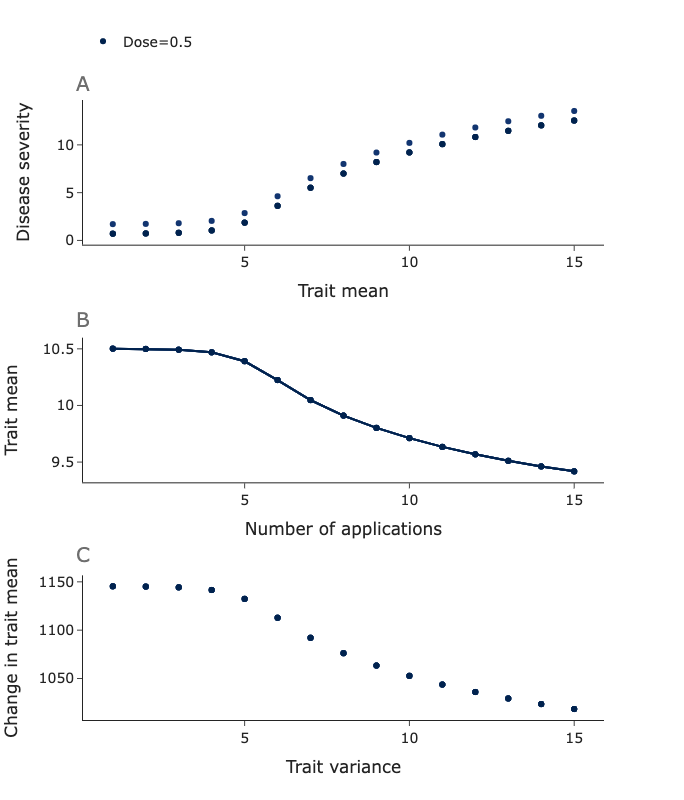

In [35]:
f = fig1(df_use)

f.show()

In [36]:
f.write_image('../figures/paper/fig1.png')